In [20]:
library(dplyr)
library(class)
library(tidyverse)
library(pROC)
library(glmnet)
library(MASS)
#install.packages('glmnetUtils')
library(glmnetUtils)


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [21]:
#lasso_pred <- readRDS("../../data/ATAC_predictions_train_XX_predict_XX/ATAC_pred_lasso_normalized_trimmed_formatted_standardized.rds")
pred <- readRDS(snakemake@input[["input_predictions"]])

In [33]:
#sample_types <- read.table("../../data/sample_types.txt", header = F, sep = " ")
sample_types <- readRDS(file = snakemake@input[["input_sample_types"]])
colnames(sample_types) <- c("sample", "sample_type")
head(sample_types)

sample,sample_type
PGDX10344P1,Gastric_cancer
PGDX10346P1,Gastric_cancer
PGDX10349P1,Gastric_cancer
PGDX10351P1,Gastric_cancer
PGDX10566P,Ovarian_Cancer
PGDX10567P,Ovarian_Cancer


In [34]:
data <- merge(pred, sample_types, by="sample")
data <- data %>% mutate(sample_type01 = ifelse(sample_type == "Healthy", 0, 1))
head(data)

sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,sample_type,sample_type01
PGDX10344P1,-4.342131,1.953977,-13.968322,2.318305,1.685676,-3.381066,6.0445212,-1.1347791,1.74198197,...,0.6274859,-2.622078,1.6339641,0.2876357,2.4162404,1.8695959,0.08770358,-1.2166196,Gastric_cancer,1
PGDX10346P1,-6.078536,-12.661175,-11.678871,-1.872324,1.336255,-1.996692,-6.4118319,7.9706470,12.11108040,...,-2.9572109,-2.308502,0.7707140,-3.6516509,-3.0050707,-1.9374279,-0.15064911,-3.4388000,Gastric_cancer,1
PGDX10349P1,48.179628,-48.671877,57.672198,10.976267,-20.122190,-4.259207,3.0733782,0.6075922,1.57203960,...,0.6475888,2.037660,-1.7877125,2.0789376,-1.0851786,-0.2287387,0.90575811,-0.9010285,Gastric_cancer,1
PGDX10351P1,-35.928939,-11.350262,-13.701368,-14.147165,-4.240782,-5.227815,-0.1563398,5.1853643,-1.26376760,...,2.4307994,5.922993,2.1776501,-2.6065181,1.8807665,2.5498882,-3.57969961,1.5642893,Gastric_cancer,1
PGDX10566P,-3.645149,-8.417624,-18.188105,-4.633597,1.470311,-1.048202,3.6578793,-1.3577985,-0.59132535,...,2.1880247,-4.290371,0.5627505,2.3363121,-0.2994595,2.8081674,2.42526637,1.0627620,Ovarian_Cancer,1
PGDX10567P,9.167948,-9.013273,9.812515,4.895645,-4.504976,4.545019,1.3597509,-2.8620042,0.01220041,...,-1.0443199,3.607826,-2.0018629,3.3426278,-1.0511282,0.7924274,0.98886233,6.8472585,Ovarian_Cancer,1


In [44]:
data <- data %>% dplyr::select(-sample_type)

In [45]:
data <- data %>% dplyr::select(-sample)
head(data)

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,sample_type01
-4.342131,1.953977,-13.968322,2.318305,1.685676,-3.381066,6.0445212,-1.1347791,1.74198197,-0.74881708,...,-2.8077276,0.6274859,-2.622078,1.6339641,0.2876357,2.4162404,1.8695959,0.08770358,-1.2166196,1
-6.078536,-12.661175,-11.678871,-1.872324,1.336255,-1.996692,-6.4118319,7.9706470,12.11108040,5.72266372,...,-1.3210358,-2.9572109,-2.308502,0.7707140,-3.6516509,-3.0050707,-1.9374279,-0.15064911,-3.4388000,1
48.179628,-48.671877,57.672198,10.976267,-20.122190,-4.259207,3.0733782,0.6075922,1.57203960,-2.84910093,...,0.7400773,0.6475888,2.037660,-1.7877125,2.0789376,-1.0851786,-0.2287387,0.90575811,-0.9010285,1
-35.928939,-11.350262,-13.701368,-14.147165,-4.240782,-5.227815,-0.1563398,5.1853643,-1.26376760,0.05546772,...,3.8996607,2.4307994,5.922993,2.1776501,-2.6065181,1.8807665,2.5498882,-3.57969961,1.5642893,1
-3.645149,-8.417624,-18.188105,-4.633597,1.470311,-1.048202,3.6578793,-1.3577985,-0.59132535,-2.49310460,...,1.2274091,2.1880247,-4.290371,0.5627505,2.3363121,-0.2994595,2.8081674,2.42526637,1.0627620,1
9.167948,-9.013273,9.812515,4.895645,-4.504976,4.545019,1.3597509,-2.8620042,0.01220041,0.19581699,...,2.7123738,-1.0443199,3.607826,-2.0018629,3.3426278,-1.0511282,0.7924274,0.98886233,6.8472585,1


In [46]:
cross_validation <- function(dataset, k_inner_cv, k_outer_cv){
    
    observed  <- dataset$sample_type01
    return_tibble <- tibble(observed = observed)
    
    for (i in 1:k_outer_cv){ # repeated Cross-validation loop
        set.seed(i)
        cvfolds <- cut(seq_len(nrow(dataset)), breaks = k_inner_cv, labels = F)
        cvfolds <- sample(cvfolds)

        predicted <- rep(NA, nrow(dataset))

        for (n in 1:k_inner_cv){
            rows      <- which(cvfolds==n)
            testdata  <- dataset[rows,]
            testlabels <- testdata$sample_type01
            testdata <- testdata %>% dplyr::select(-sample_type01)

            traindata <- dataset[-rows,]
            trainlabels <- traindata$sample_type01
            #traindata <- traindata %>% dplyr::select(-sample_type01)


            fit       <- lda(sample_type01 ~ ., data=traindata)
            prediction <- predict(fit, testdata)
            predicted[rows] <- prediction$posterior[,2]
        }
        
    current_round_tibble <- tibble(predicted = predicted)
    return_tibble <- cbind(return_tibble, current_round_tibble)
    } # end of outer cv loop

    return(return_tibble)
}

In [47]:
results <- as.data.frame(cross_validation(data, k_inner_cv = 10, k_outer_cv = 10))

In [48]:
results <- tibble(results, .name_repair = "unique")
head(results)

New names:
* predicted -> predicted...2
* predicted -> predicted...3
* predicted -> predicted...4
* predicted -> predicted...5
* predicted -> predicted...6
* ...


observed,predicted...2,predicted...3,predicted...4,predicted...5,predicted...6,predicted...7,predicted...8,predicted...9,predicted...10,predicted...11
1,0.3436612,0.6801321,0.3410724,0.4460276,0.3714559,0.3395366,0.6577503,0.3651524,0.4175338,0.4188710
1,0.4314549,0.2076484,0.4243601,0.4769424,0.4580539,0.3264093,0.3089825,0.3425262,0.1353414,0.1367788
1,0.9794671,0.9869055,0.9838237,0.9844531,0.9782503,0.9793649,0.9800792,0.9733342,0.9874479,0.9827637
1,0.2794645,0.2610130,0.1865214,0.1684457,0.2974522,0.1473623,0.2752325,0.5666697,0.5591218,0.1593999
1,0.7125422,0.7607799,0.8604535,0.7266700,0.8019640,0.7847162,0.8056162,0.6810949,0.7743292,0.7469585
1,0.8581353,0.8693567,0.9292935,0.8889015,0.7587556,0.8092268,0.8288329,0.8452354,0.8599730,0.8097178


In [49]:
saveRDS(results, file = snakemake@output[["LDA_output"]])

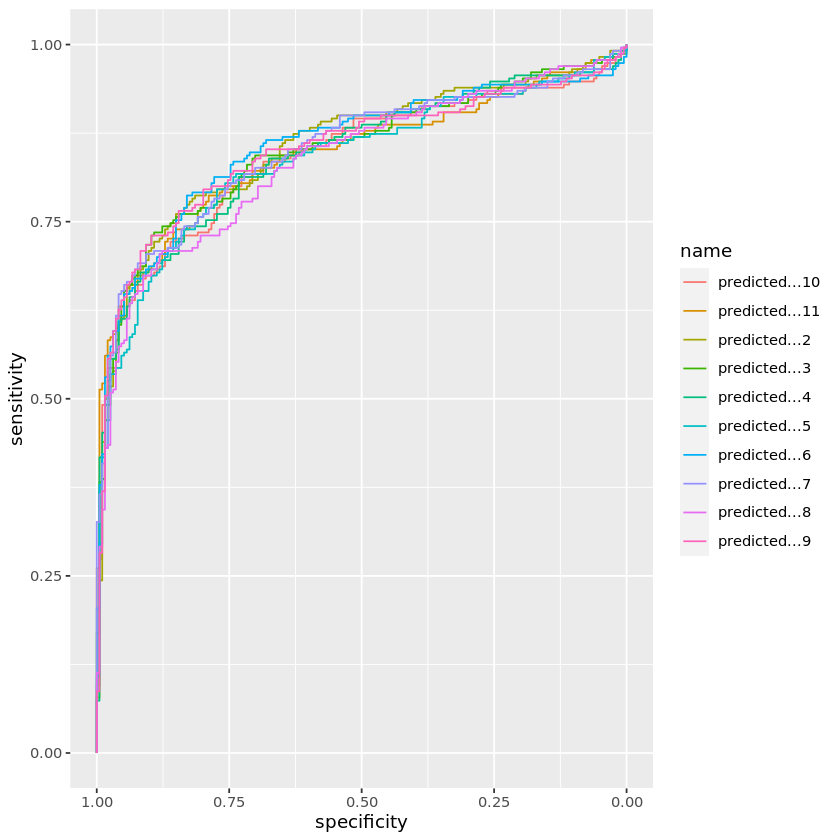

In [51]:
# Create multiple curves to plot
rocs <- roc(observed ~ predicted...2 + 
                    predicted...3 + 
                    predicted...4 + 
                    predicted...5 + 
                    predicted...6 +
                    predicted...7 +
                    predicted...8 + 
                    predicted...9 + 
                    predicted...10 + 
                    predicted...11, data = results)
ggroc(rocs)

In [52]:

dim(results$observed)

NULL

In [54]:
roc1 <- roc(results$observed, results$predicted...2)
roc2 <- roc(results$observed, results$predicted...3)
roc3 <- roc(results$observed, results$predicted...4)
roc4 <- roc(results$observed, results$predicted...5)
roc5 <- roc(results$observed, results$predicted...6)
roc6 <- roc(results$observed, results$predicted...7)
roc7 <- roc(results$observed, results$predicted...8)
roc8 <- roc(results$observed, results$predicted...9)
roc9 <- roc(results$observed, results$predicted...10)
roc10 <- roc(results$observed, results$predicted...11)

In [57]:
paste("Mean AUC over 10 repetitions of 10-fold CV: ", mean(c(roc1$auc, roc2$auc, roc3$auc, roc4$auc, roc5$auc, roc6$auc, roc7$auc, roc8$auc, roc9$auc, roc10$auc)), sep = "")

[1] "Mean AUC over 10 repetitions of 10-fold CV: 0.847187359928283"

In [59]:
results_01 <- results %>% mutate(predicted...2_01 = ifelse(predicted...2 > 0.5, 1, 0), 
                                 predicted...3_01 = ifelse(predicted...3 > 0.5, 1, 0), 
                                 predicted...4_01 = ifelse(predicted...4 > 0.5, 1, 0),
                                 predicted...5_01 = ifelse(predicted...5 > 0.5, 1, 0),
                                 predicted...6_01 = ifelse(predicted...6 > 0.5, 1, 0),
                                 predicted...7_01 = ifelse(predicted...7 > 0.5, 1, 0),
                                 predicted...8_01 = ifelse(predicted...8 > 0.5, 1, 0),
                                 predicted...9_01 = ifelse(predicted...9 > 0.5, 1, 0),
                                 predicted...10_01 = ifelse(predicted...10 > 0.5, 1, 0),
                                 predicted...11_01 = ifelse(predicted...11 > 0.5, 1, 0))

In [60]:
error_rates <- c(mean(results_01$observed != results_01$predicted...2_01), 
                mean(results_01$observed != results_01$predicted...3_01),
               mean(results_01$observed != results_01$predicted...4_01),
               mean(results_01$observed != results_01$predicted...5_01),
               mean(results_01$observed != results_01$predicted...6_01),
               mean(results_01$observed != results_01$predicted...7_01),
               mean(results_01$observed != results_01$predicted...8_01),
               mean(results_01$observed != results_01$predicted...9_01), 
               mean(results_01$observed != results_01$predicted...10_01), 
               mean(results_01$observed != results_01$predicted...11_01))

error_rates

paste("Mean error rate over 10 repetitions of 10-fold CV: ", mean(error_rates), sep = "")

[1] 0.2051887 0.1981132 0.2240566 0.2264151 0.2146226 0.2122642 0.2146226
 [8] 0.1957547 0.2169811 0.2169811

[1] "Mean error rate over 10 repetitions of 10-fold CV: 0.2125"

In [61]:
accuracies <- c(mean(results_01$observed == results_01$predicted...2_01),
               mean(results_01$observed == results_01$predicted...3_01), 
               mean(results_01$observed == results_01$predicted...4_01),
               mean(results_01$observed == results_01$predicted...5_01),
               mean(results_01$observed == results_01$predicted...6_01),
               mean(results_01$observed == results_01$predicted...7_01),
               mean(results_01$observed == results_01$predicted...8_01),
               mean(results_01$observed == results_01$predicted...9_01), 
               mean(results_01$observed == results_01$predicted...10_01), 
               mean(results_01$observed == results_01$predicted...11_01))

accuracies
paste("Mean accuracy over 10 repetitions of 10-fold CV: ", mean(accuracies), sep = "")

[1] 0.7948113 0.8018868 0.7759434 0.7735849 0.7853774 0.7877358 0.7853774
 [8] 0.8042453 0.7830189 0.7830189

[1] "Mean accuracy over 10 repetitions of 10-fold CV: 0.7875"